In [133]:
import numpy as np
import matplotlib.pyplot as plt

In [134]:
def gaussian_data(mus, covmats, n):
    g1 = np.random.multivariate_normal(mus[0], covmats[0], int(n / 2))
    y1 = np.ones((int(n / 2), 1))
    xy1 = np.concatenate((g1, y1), axis=1)
    g2 = np.random.multivariate_normal(mus[1], covmats[1], int((n + 1) / 2))
    y2 = - np.ones((int((n + 1) / 2), 1))
    xy2 = np.concatenate((g2, y2), axis=1)
    xy = np.concatenate((xy1, xy2), axis=0)
    np.random.shuffle(xy)
    return xy                      

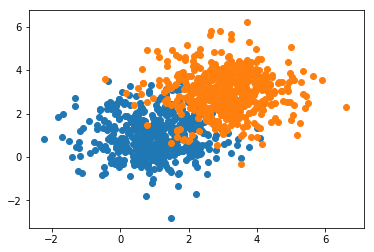

In [135]:
xy = gaussian_data(([1, 1], [3, 3]), (np.eye(2), np.eye(2)), 1000)
positive = xy[xy[:, 2] == 1]
negative = xy[xy[:, 2] == -1]
plt.scatter(positive[:, 0], positive[:, 1])
plt.scatter(negative[:, 0], negative[:, 1])
plt.show()
xmat = xy[:, :2].T
y = xy[:, 2:].T

## LossFunc class
We create here an almost empty class model for losses functions. The objective is to be able to change loss function easily

In [136]:
class LossFunc:
    
    def __init__(self):
        self.primal = None
        self.dual = None
        self.sdca_update = None
        self.sgd_update = None
    
    def set_primal(self, func):
        self.primal = func
    
    def set_dual(self, func):
        self.dual = func
    
    def set_sdca_update(self, func):
        self.sdca_update = func
    
    def set_sgd_update(self, func):
        self.sgd_update = func

We define the hinge loss using the class framework defined above

In [137]:
def vector_hinge_loss(a, y):
    return np.maximum(0, 1 - y * a)

def vector_hinge_dual(alpha, y):
    prod = alpha * y
    prod[prod > 0] = np.inf
    prod[prod < -1] = np.inf
    return prod

def hinge_delta_alpha(w, xi, yi, alphai, lamb):
    n = xi.shape[0]
    q = lamb * n * (1 - np.dot(xi.T, w) * yi) / np.power(np.linalg.norm(xi), 2)
    q += alphai
    return max(-1, min(1, q)) - alphai
    
hinge = LossFunc()
hinge.set_primal(vector_hinge_loss)
hinge.set_dual(vector_hinge_dual)
hinge.set_sdca_update(hinge_delta_alpha)

## Primal and dual of cumulative regularized loss
We define in this section:
1. Some intermediaries functions
1. The primal dual correspondance function (associating w(alpha) to alpha)
1. The primal and dual cumulative loss functions
1. The duality gap function

In [138]:
def w_dot_xmat(w, xmat):
    return np.dot(np.transpose(w), xmat)

In [139]:
def cum_loss(w, xmat, y, lamb, lossfunc=hinge):
    a = w_dot_xmat(w, xmat) 
    cumloss = np.mean(lossfunc.primal(a, y))
    reg = (lamb / 2) * np.power(np.linalg.norm(w), 2)
    return cumloss + reg

In [140]:
def alpha_to_w(alpha, xmat, lamb):
    n = xmat.shape[1]
    return (1 / (n * lamb)) * np.dot(xmat, alpha.T)

In [141]:
def cum_loss_dual(alpha, xmat, y, lamb, lossfunc=hinge):
    cumlossdual = np.mean(- lossfunc.dual(- alpha, y))
    w = alpha_to_w(alpha, xmat, lamb)
    reg = (lamb / 2) * np.power(np.linalg.norm(w), 2)
    return cumlossdual + reg

In [142]:
# Test for those few first functions
w_test = np.array([1, 1])
w_test = w_test.reshape((2, 1))
a = w_dot_xmat(w_test, xmat)
h = vector_hinge_loss(a, y)
cumloss = cum_loss(w_test, xmat, y, 1)
n = y.shape[1]
alpha_test = 0.5 * np.ones((1, n))
cum_loss_dual(alpha_test, xmat, y, 1)

-inf

In [143]:
def duality_gap(alpha, xmat, y, lamb, lossfunc=hinge):
    w = alpha_to_w(alpha, xmat, lamb)
    p = cum_loss(w, xmat, y, lamb, lossfunc)
    d = cum_loss_dual(alpha, xmat, y, lamb, lossfunc)
    return p - d

## Modified SGD for initialization

We wish to find $\alpha_t$ that maximizes : 
$$ - \phi_t^{\star}(-\alpha_t) - \frac{\lambda t}{2} ||w^{(t-1)} + (\lambda t)^{-1} \alpha_t x_t ||^2$$

Developping the previous expression yields : 
$$ \alpha_t y_t - \frac{\lambda t}{2} ( ||w^{(t-1)}||^2 + 2 \frac{\alpha_t}{\lambda t} \langle w^{(t-1)}, x_t \rangle + \frac{\alpha_t^2}{\lambda^2 t^2}||x_t||^2 )$$

This is a second order polynomial in $\alpha_t$. With a negative coefficient on the second order term. Thus this is concave. Setting the derivative w.r.t $\alpha_t$ yields : 

$$ y_t - \langle w^{(t-1)}, x_t \rangle - \frac{\alpha_t^2}{2 \lambda t} = 0$$


This gives us an optimal $\alpha_t$ which is given by : 
$$ \alpha_t= \frac{\lambda t}{||x_t||^2} (y_t - x_t^T w^{(t-1)})$$

In [144]:
def hinge_sgd_update(w, xt, yt, lamb, t):
    wdotx = np.dot(xt.T, w)
    xsqrnorm = np.power(np.linalg.norm(xt), 2)
    return ((lamb * t) / xsqrnorm) * (yt - wdotx)

hinge.set_sgd_update(hinge_sgd_update)

In [145]:
def modified_sgd(xmat, y, lamb, lossfunc=hinge):
    d = xmat.shape[0]
    n = xmat.shape[1]
    alpha = np.zeros((1, n))
    w = np.zeros((d, 1))
    for t in range(0, n):
        alpha[0, t] = lossfunc.sgd_update(w, xmat[:, t], y[0, t], lamb, t)
        w = alpha_to_w(alpha[:, :t + 1], xmat[:, :t + 1], lamb)
    return alpha, w       

In [146]:
alpha0, w0 = modified_sgd(xmat, y, 1)

## SDCA Perm

In [147]:
def sdca_perm(alpha0, xmat, y, lamb, nmax_epochs, epsilon, lossfunc=hinge):
    n = xmat.shape[1]
    alpha = alpha0.copy()
    w = alpha_to_w(alpha0, xmat, lamb)
    loss_track = []
    loss_track.append(cum_loss(w, xmat, y, lamb, lossfunc))
    inds = np.array(range(0, n))
    np.random.shuffle(inds)
    gap = np.inf
    k = 0
    while (gap > epsilon) and (k < nmax_epochs) :
        inds = np.array(range(0, n))
        np.random.shuffle(inds)
        for j in range(0, n):
            i = inds[j]
            delta = lossfunc.sdca_update(w, xmat[:, i], y[0, i], alpha[0, i], lamb)
            alpha[0, i] += delta
            w += ((1 / (lamb * n)) * delta * xmat[:, i]).reshape((2, 1))
        k += 1
        loss_track.append(cum_loss(w, xmat, y, lamb, lossfunc))
        gap = duality_gap(alpha, xmat, y, lamb, lossfunc)
    return w, alpha, loss_track

In [151]:
wstar, alphastar, hist = sdca_perm(alpha0, xmat, y, 1, 100, 0.0001)

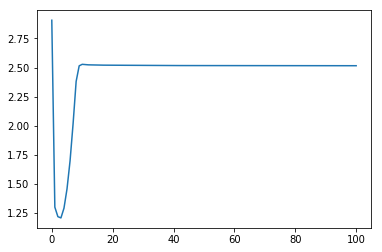

array([[-1.01744907],
       [-0.9950242 ]])

In [152]:
plt.plot(hist)
plt.show()
wstar

In [153]:
def hyperplane(w, xgrid):
    return (-w[0, 0] / w[1, 0]) * xgrid

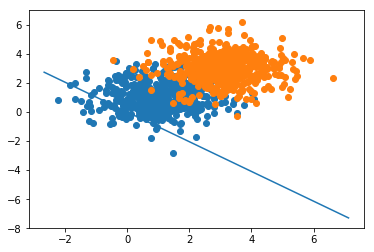

In [154]:
positive = xy[xy[:, 2] == 1]
negative = xy[xy[:, 2] == -1]
fig = plt.figure()
plt.scatter(positive[:, 0], positive[:, 1])
plt.scatter(negative[:, 0], negative[:, 1])
ax = fig.axes[0]
xlim = ax.get_xlim()
xgrid = np.linspace(xlim[0], xlim[1], 1000)
sep = (xgrid, hyperplane(wstar, xgrid))
ax.plot(sep[0], sep[1])
plt.show()

In [128]:
fig = plt.figure()
ax = fig.axes

In [129]:
ax

[]